In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# a)

In [30]:
#Units Constants
G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
c = 299792458    # Speed of light (m/s)
solar_mass = 1.989e30  # Solar mass (kg)
length_unit = 1477
time_unit = 4.927e-6
pressure_limit = 1e-8


pi = np.pi

In [134]:
def polytope(K, rho):
    return K*(rho**2)

# TOV equations:

# def dm_dr(r):
#     return 4*pi*r**2*rho

# def dnu_dr(r):
#     return 2*(m + 4*pi * r**3 * rho) / (r * (r - 2*m))

# def dp_dr(r):
#     return -0.5 * (rho + p) * dv_dr(r)

def tov_equations(r, y):
    m, nu, p = y
    rho = (p / K)**(1/2) if p > 0 else 0
    
    if p <= 0:  # Stop condition
        return [0, 0, 0]
    
    if r == 0:
        dm_dr = 4 * pi * r**2 * rho
        dnu_dr = 0
        dp_dr = 0
    else:
        dm_dr = 4 * np.pi * r**2 * rho
        dnu_dr =  2*(m + 4*pi * r**3 * p) / (r * (r - 2*m))
        dp_dr =  -0.5 * (rho + p) * nu
    return [dm_dr, dnu_dr, dp_dr]

# Stop condition: Pressure drops to zero
def pressure_zero(r, y):
    return y[2]  # Pressure is the third element in y

pressure_zero.terminal = True


def solve_tov(p_c):
    r_init = 1e-6  # Avoid singularity at the center
    m_init = 0  # Initial mass is zero
    nu_init = 0
    y_init = np.asarray([m_init,nu_init, p_c]).astype(float)

    # Integration using Runge-Kutta 4
    r_span = [r_init, 1e5]  # Adjust the upper bound as needed
    sol = solve_ivp(tov_equations, r_span, y_init, method='RK45', rtol=1e-6, atol=1e-6, events=pressure_zero)

    
    return sol.y[0,-1], sol.t[-1]
    





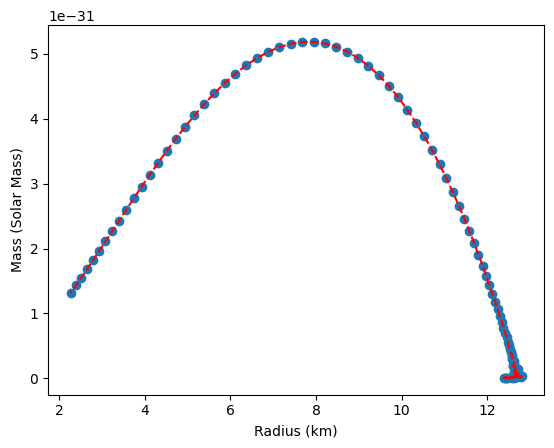

In [135]:
# Equation Parameters
K = 200
N = 100 # Sample size

# Preparing 
rho_vals = np.logspace(-6,-1, N)
central_pressures = polytope(K, rho_vals)  # vary central pressures
masses = []
radii = []

for p_c in central_pressures:
    sol = solve_tov(p_c)
    m, r = sol
    masses.append(m / solar_mass)  # convert to solar masses
    radii.append(r / 1000 )  # convert to kilometers

radii = np.asarray(radii).astype(float)
masses = np.asarray(masses).astype(float)

#Plot the result
plt.figure()
plt.scatter(x=radii*length_unit, y=masses)
plt.plot(radii*length_unit, masses, '--', color='red')
plt.xlabel('Radius (km)')
plt.ylabel('Mass (Solar Mass)')
plt.show()

# b)

In [136]:
def tov_equations_part_b(r, y):
    m, nu, p, mp = y
    rho = (p / K)**(1/2) if p > 0 else 0
    
    if p <= 0:  # Stop condition
        return [0, 0, 0, 0]
    
    if r == 0:
        dmp_dr = o
        dnu_dr = 0
        dp_dr = 0
    else:
        dm_dr = 4 * np.pi * r**2 * rho
        dnu_dr =  2*(m + 4*pi * r**3 * p) / (r * (r - 2*m))
        dp_dr =  -0.5 * (rho + p) * nu
        
        # additionally return dmp_dr
        dmp_dr = 4*pi * (1 - 2*m/r)**(-1/2) * r**2 * rho
    return [dm_dr, dnu_dr, dp_dr, dmp_dr]

def solve_tov_part_b(p_c):
    r_init = 1e-6  # Avoid singularity at the center
    m_init = 0  # Initial mass is zero
    nu_init = 0
    mp_init = 0
    y_init = np.asarray([m_init,nu_init, p_c, mp_init]).astype(float)

    # Integration using Runge-Kutta 4
    r_span = [r_init, 1e5]  # Adjust the upper bound as needed
    sol = solve_ivp(tov_equations_part_b, r_span, y_init, method='RK45', rtol=1e-6, atol=1e-6, events=pressure_zero)

    
    return sol.y[0,-1], sol.t[-1], sol.y[3, -1] # additionally return mp
    

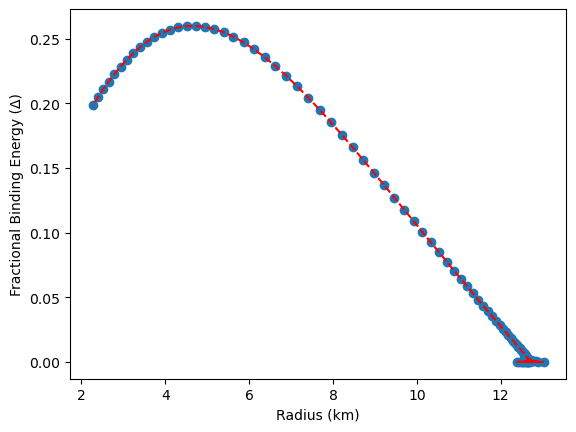

In [139]:
# computing delta values 
delta_vals = []
masses = []
radii = []
for p_c in central_pressures:
    m, r, m_p = solve_tov_part_b(p_c)

    if m > 0: # avoid division by zero
        delta = (m_p - m) / m
        delta_vals.append(delta)
        masses.append(m / solar_mass) # convert to solar masses
        radii.append(r / 1000) # convert to kilometers

radii = np.asarray(radii).astype(float)
delta_vals = np.asarray(delta_vals).astype(float)

# plotting delta vs R

plt.figure()
plt.scatter(x=radii * length_unit, y=delta_vals)
plt.plot(radii * length_unit, delta_vals, '--', color='red')
plt.xlabel('Radius (km)')
plt.ylabel('Fractional Binding Energy (Δ)')
plt.show()



# c)

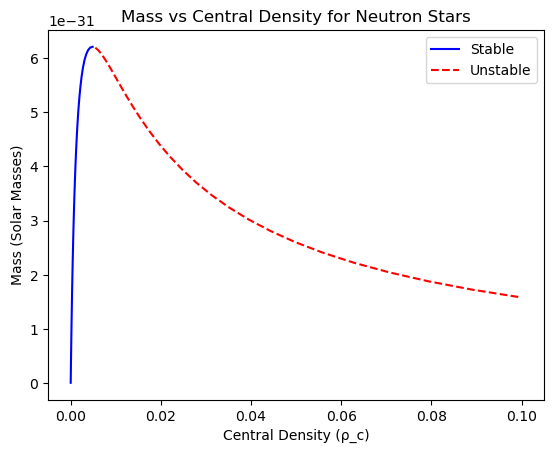

Maximal Neutron Star Mass: 0.00 Solar Masses


In [143]:
masses = []
rho_c_vals = rho_vals

for p_c in central_pressures:
    _, _, mp = solve_tov_part_b(p_c)
    masses.append(mp / solar_mass)  # Convert to solar masses

masses = np.asarray(masses)

# Compute dM/dρc
dMp_dRho = np.gradient(masses, rho_c_vals)

# Identify stable and unstable regions
stable_rho_c = rho_c_vals[dMp_dRho > 0]
unstable_rho_c = rho_c_vals[dMp_dRho < 0]
stable_masses = masses[dMp_dRho > 0]
unstable_masses = masses[dMp_dRho < 0]

# Plotting
plt.figure()
plt.plot(stable_rho_c, stable_masses, label='Stable', color='blue')
plt.plot(unstable_rho_c, unstable_masses, label='Unstable', linestyle='dashed', color='red')
plt.xlabel('Central Density (ρ_c)')
plt.ylabel('Mass (Solar Masses)')
plt.title('Mass vs Central Density for Neutron Stars')
plt.legend()
plt.show()

# Report maximal NS mass
max_mass = np.max(masses)
print(f"Maximal Neutron Star Mass: {max_mass:.2f} Solar Masses")